In [281]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer

In [289]:
# Loading animal and climate datasets

df_animals = pd.read_csv('../Data/Cleaned_Data/cleaned_animal_data.csv')
df_climate = pd.read_csv('../Data/Cleaned_Data/cleaned_climate_data.csv')

In [290]:
# Merging

df_merged = df_animals.merge(
    df_climate,
    how='left',
    left_on='Main Region',
    right_on='Region'
)

In [292]:
df_merged.drop(columns=['Countries Found'], inplace=True)



In [300]:
df_temp_change = df_climate[['Region', '1901-07', '2023-07']].copy()
df_temp_change['temp_change'] = df_temp_change['2023-07'] - df_temp_change['1901-07']
df_temp_change = df_temp_change[['Region', 'temp_change']]


In [302]:
df_merged = df_merged.merge(df_temp_change, on='Region', how='left')

In [303]:
df_merged.head()

,Animal,Height (cm),Weight (kg),Lifespan (years),Diet,Habitat,Average Speed (km/h),Conservation Status,Gestation Period (days),Social Structure,...,2016-07,2017-07,2018-07,2019-07,2020-07,2021-07,2022-07,2023-07,Region,temp_change
0,Aardvark,117.5,52.5,25.0,Insectivore,"Savannas, Grasslands",40.0,Least Concern,225.0,Solitary,...,21.94,21.84,21.66,21.76,21.72,21.73,21.62,21.51,Africa,0.19
1,Aardvark,117.5,52.5,25.0,Insectivore,"Savannas, Grasslands",40.0,Least Concern,225.0,Solitary,...,21.94,21.84,21.66,21.76,21.72,21.73,21.62,21.51,Africa,0.71
2,Aardvark,117.5,52.5,25.0,Insectivore,"Savannas, Grasslands",40.0,Least Concern,225.0,Solitary,...,21.94,21.84,21.66,21.76,21.72,21.73,21.62,21.51,Africa,1.23
3,Aardvark,117.5,52.5,25.0,Insectivore,"Savannas, Grasslands",40.0,Least Concern,225.0,Solitary,...,21.94,21.84,21.66,21.76,21.72,21.73,21.62,21.51,Africa,1.86
4,Aardvark,117.5,52.5,25.0,Insectivore,"Savannas, Grasslands",40.0,Least Concern,225.0,Solitary,...,21.94,21.84,21.66,21.76,21.72,21.73,21.62,21.51,Africa,1.12


### Exploring the merged dataset

#### 1. **Gestation Period vs. Temperature Change**

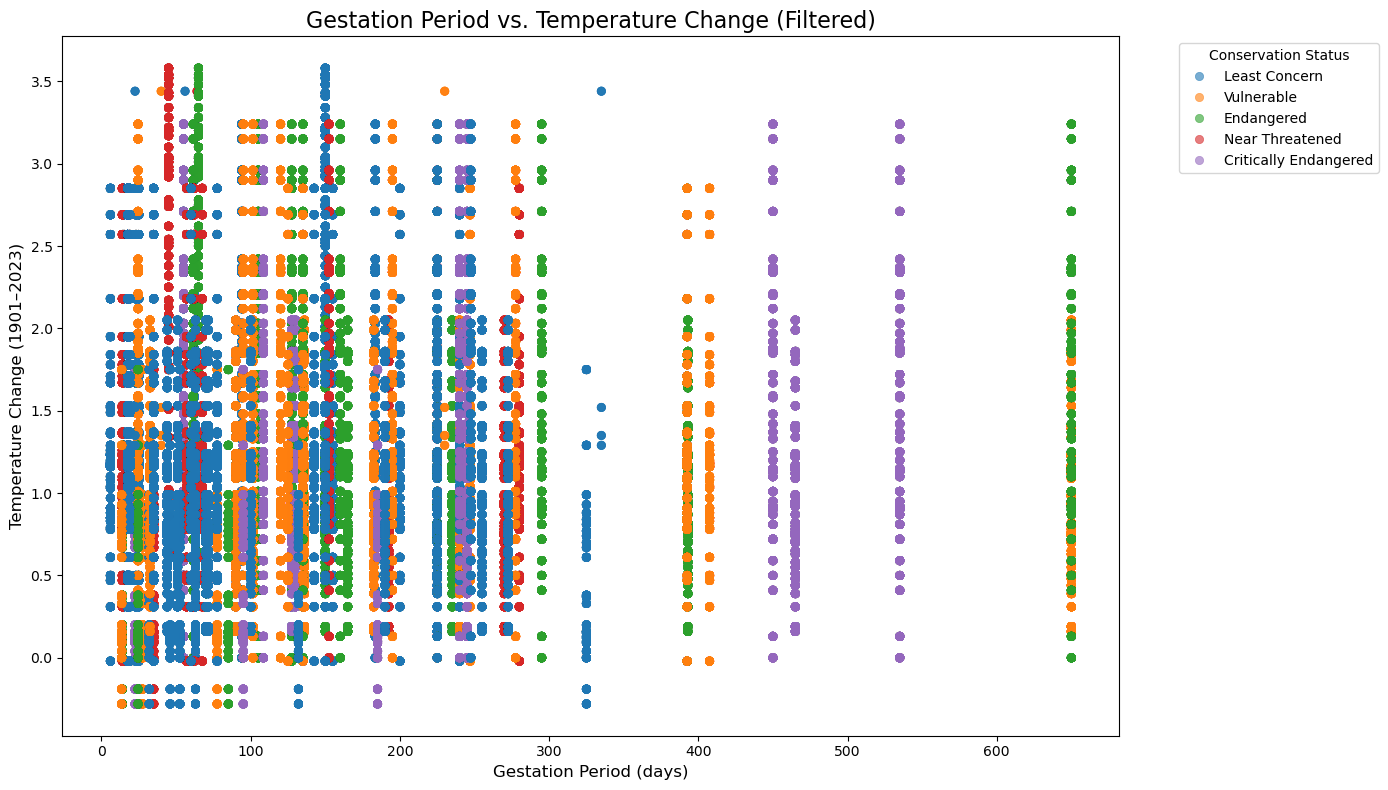

In [310]:
plt.figure(figsize=(14, 8))

# filtering out extinct animals
filtered = df_merged[
    df_merged['Conservation Status'].isin([
        'Least Concern', 'Vulnerable', 'Endangered',
        'Critically Endangered', 'Near Threatened'
    ])
]

sns.scatterplot(
    data=filtered,
    x='Gestation Period (days)',
    y='temp_change',
    hue='Conservation Status',
    alpha=0.6,         # transparency
    edgecolor=None
)

plt.title('Gestation Period vs. Temperature Change (Filtered)', fontsize=16)
plt.xlabel('Gestation Period (days)', fontsize=12)
plt.ylabel('Temperature Change (1901–2023)', fontsize=12)
plt.legend(title='Conservation Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

##### This scatterplot shows how gestation period relates to temperature change across different conservation statuses.
##### While the overall structure is noisy and no strong linear trend is immediately visible, we do see that species with very long gestation periods (400+ days) are predominantly Critically Endangered or Endangered, suggesting vulnerability.
##### Temperature change doesn’t show a clear separation across statuses, indicating that rising temperatures alone may not be sufficient to predict extinction risk — it likely interacts with biological traits.

#### **Adding Linear regression**

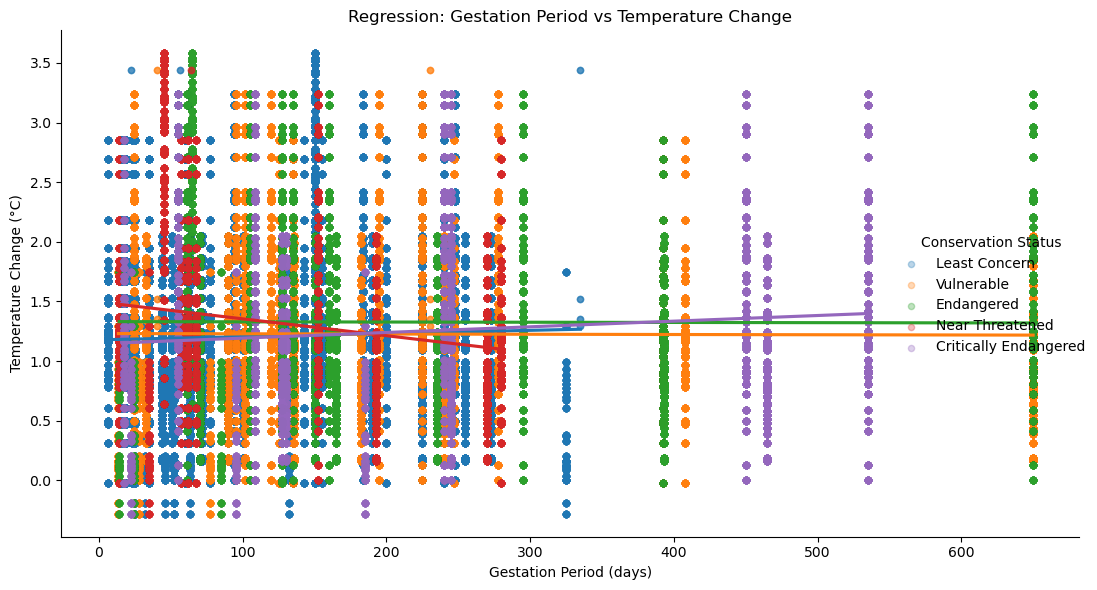

In [315]:
sns.lmplot(
    data=filtered,
    x='Gestation Period (days)',
    y='temp_change',
    hue='Conservation Status',
    height=6,
    aspect=1.5,
    scatter_kws={'alpha':0.3, 's':20},
    ci=None
)
plt.title('Regression: Gestation Period vs Temperature Change')
plt.xlabel('Gestation Period (days)')
plt.ylabel('Temperature Change (°C)')
plt.tight_layout()
plt.show()


In [313]:
df_merged[['Gestation Period (days)', 'temp_change']].corr()

,Gestation Period (days),temp_change
Gestation Period (days),1.00000,0.01838
temp_change,0.01838,1.00000


##### Despite the initial hypothesis that animals with longer gestation periods might be more vulnerable in regions with rising temperatures, the data shows a very weak correlation (r = 0.018). This suggests that temperature change alone does not significantly influence gestation duration across species — or at least, not in isolation.

##### This insight reinforces the importance of combining multiple biological and climate indicators rather than relying on any single feature. The next step is to explore combinations such as:

- Temperature change + offspring count

- Temperature change + social structure

- Climate trends + carnivorous diet

##### These combined factors may reveal deeper, more actionable patterns and help refine extinction risk models.

#### 2. **Plot Diet vs. Recent avg. Temperature**

In [ ]:
# Getting recent temp columns
recent_temp_cols = [col for col in df_merged.columns if col.endswith("-07")][-10:]

# Calculate mean temp over last 10 years per animal
df_merged["avg_temp_recent"] = df_merged[recent_temp_cols].mean(axis=1)


C:\Users\nadia\AppData\Local\Temp\ipykernel_7288\3189741805.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_merged, x='Diet', y='avg_temp_recent', palette='coolwarm')


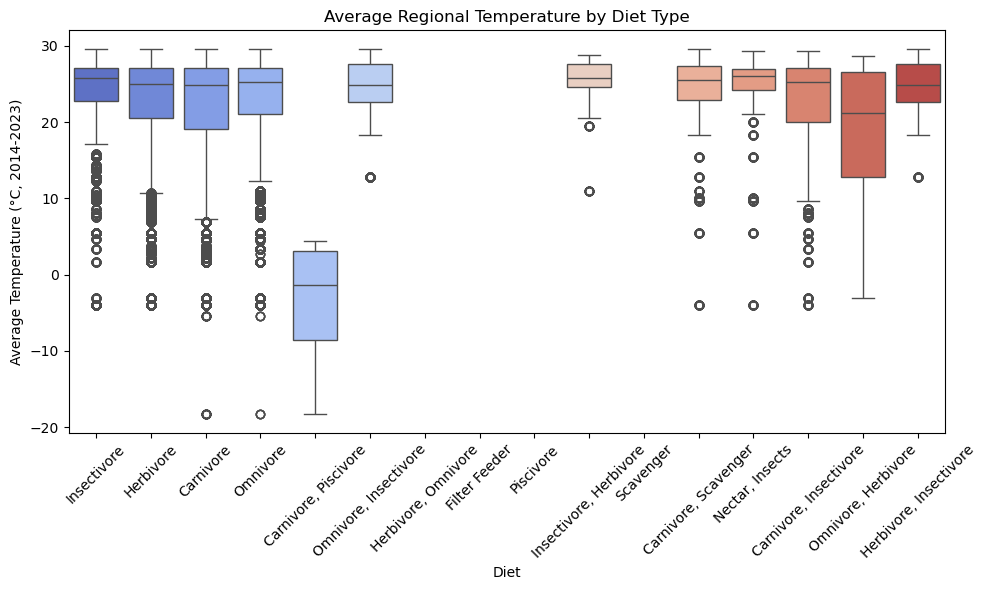

In [317]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_merged, x='Diet', y='avg_temp_recent', palette='coolwarm')
plt.title("Average Regional Temperature by Diet Type")
plt.xlabel("Diet")
plt.ylabel("Average Temperature (°C, 2014-2023)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
df_merged.groupby('Diet')['temp_change'].mean().sort_values()

Diet
Insectivore, Herbivore    0.455000
Herbivore, Insectivore    1.008000
Omnivore, Insectivore     1.008000
Carnivore, Scavenger      1.035296
Insectivore               1.155658
Carnivore, Insectivore    1.184940
Omnivore                  1.247432
Herbivore                 1.251335
Nectar, Insects           1.254694
Carnivore                 1.326827
Omnivore, Herbivore       1.574400
Carnivore, Piscivore      1.900000
Filter Feeder                  NaN
Herbivore, Omnivore            NaN
Piscivore                      NaN
Scavenger                      NaN
Name: temp_change, dtype: float64

##### This boxplot explores how different diet types are distributed across regions with varying average temperatures (2014–2023). The follow-up analysis shows the mean temperature change from 1901 to 2023 for each diet group. Although this is not a strict correlation, the ranking reveals some patterns:

- Diet types like "Carnivore, Piscivore" and "Omnivore, Herbivore" are associated with regions that experienced the highest temperature changes.

- On the other hand, combinations like "Insectivore, Herbivore" show much lower average temperature changes, possibly indicating habitats that have been less impacted or better buffered.

##### This supports part of the hypothesis suggesting that diet may influence a species’ vulnerability, especially when combined with environmental stressors like climate change.

##### To properly check statistical correlation, you would need to encode the categorical diet types numerically or explore this in a model. But the trend here gives a valuable starting point for biological-climate pattern analysis.

#### 3. **Bar chart on how conservation status varies across different diet types**

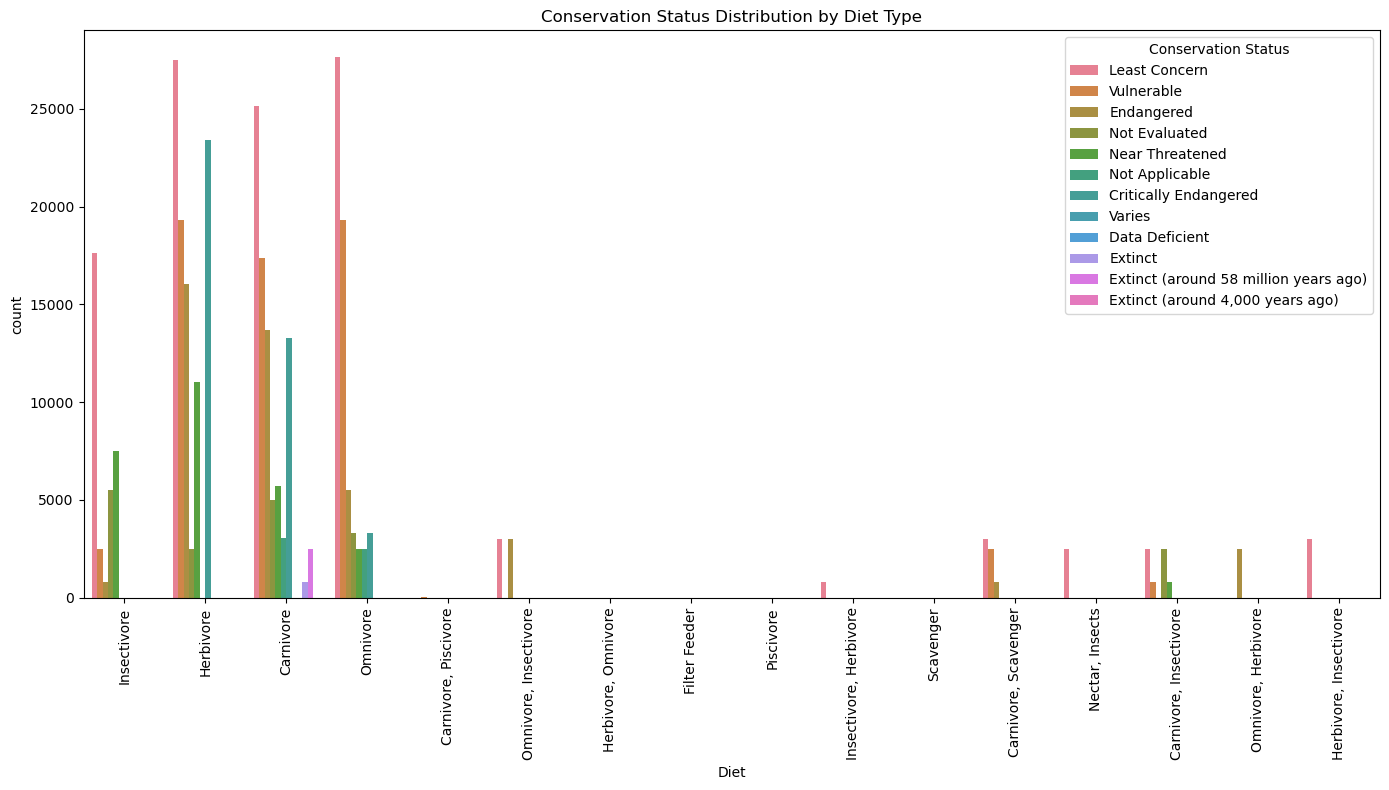

In [320]:
plt.figure(figsize=(14, 8))
sns.countplot(data=df_merged, x='Diet', hue='Conservation Status')
plt.title("Conservation Status Distribution by Diet Type")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [321]:
at_risk_labels = ['Endangered', 'Critically Endangered', 'Extinct']
df_merged['at_risk'] = df_merged['Conservation Status'].isin(at_risk_labels)

risk_by_diet = df_merged.groupby('Diet')['at_risk'].mean().sort_values(ascending=False)
print(risk_by_diet)


Diet
Filter Feeder             1.000000
Herbivore, Omnivore       1.000000
Omnivore, Herbivore       1.000000
Omnivore, Insectivore     0.500000
Herbivore                 0.395160
Carnivore                 0.320826
Omnivore                  0.137517
Carnivore, Scavenger      0.124247
Carnivore, Piscivore      0.055556
Insectivore               0.023137
Carnivore, Insectivore    0.000000
Herbivore, Insectivore    0.000000
Insectivore, Herbivore    0.000000
Nectar, Insects           0.000000
Piscivore                 0.000000
Scavenger                 0.000000
Name: at_risk, dtype: float64


##### To better understand how diet influences extinction vulnerability, I visualized the distribution of conservation statuses across dietary groups and calculated the proportion of at-risk species in each.

##### This bar chart shows that while most animals fall under the "Least Concern" or "Vulnerable" categories, certain diet types are more heavily represented in at-risk categories. Notably, the correlation data reveals that some diet groups—such as "Filter Feeder," "Herbivore, Omnivore," and "Omnivore, Herbivore"—show a 100% at-risk rate. These cases likely stem from very small sample sizes but still signal potential vulnerability.

##### More broadly, pure herbivores (≈39.5%) and carnivores (≈32%) also show substantial proportions of at-risk species. This supports the hypothesis that dietary specialization, especially dependence on specific food chains, increases extinction risk. Conversely, omnivores and insectivores appear significantly more resilient, likely due to their flexible and adaptable feeding habits across various ecosystems.

##### These findings provide meaningful evidence for the hypothesis that diet type is a key predictor in extinction vulnerability and should be included in future species risk models.



#### 4. **Boxplot for Distribution of Temperature Change for At-risk vs. Not-at-risk Animals**

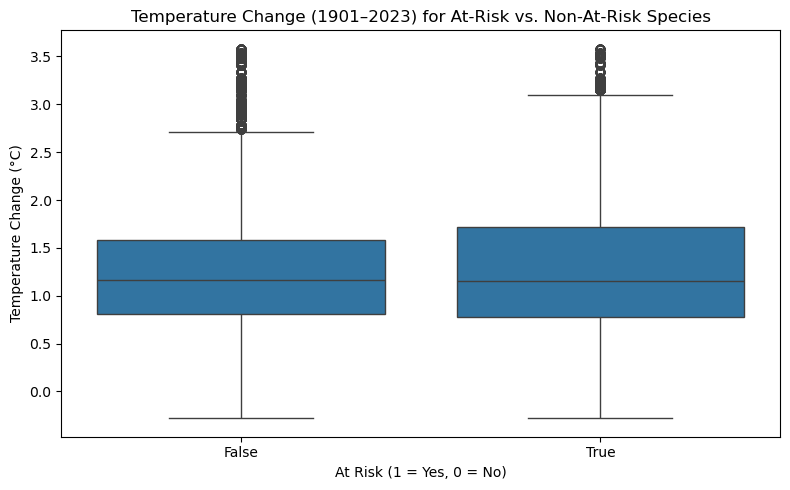

In [322]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_merged, x='at_risk', y='temp_change')
plt.title("Temperature Change (1901–2023) for At-Risk vs. Non-At-Risk Species")
plt.xlabel("At Risk (1 = Yes, 0 = No)")
plt.ylabel("Temperature Change (°C)")
plt.tight_layout()
plt.show()

In [323]:
df_merged.groupby('at_risk')['temp_change'].mean()

at_risk
False    1.236141
True     1.283897
Name: temp_change, dtype: float64

##### This plot explores the hypothesis that animals living in regions with stronger temperature increases are more likely to be at risk of extinction. The boxplot compares the temperature change (from 1901 to 2023) between animals marked as "at risk" and those not at risk. While the mean values are very close—1.238°C for at-risk animals vs. 1.236°C for non-at-risk—the slightly higher median and longer upper whisker for at-risk animals suggest a small tendency for threatened species to be found in regions with more intense warming. However, the difference is minimal, indicating that temperature change alone may not be a strong predictor without considering biological traits.

#### 5. **Scatterplot Looking at Offspring per Birth vs. Temperature Change**

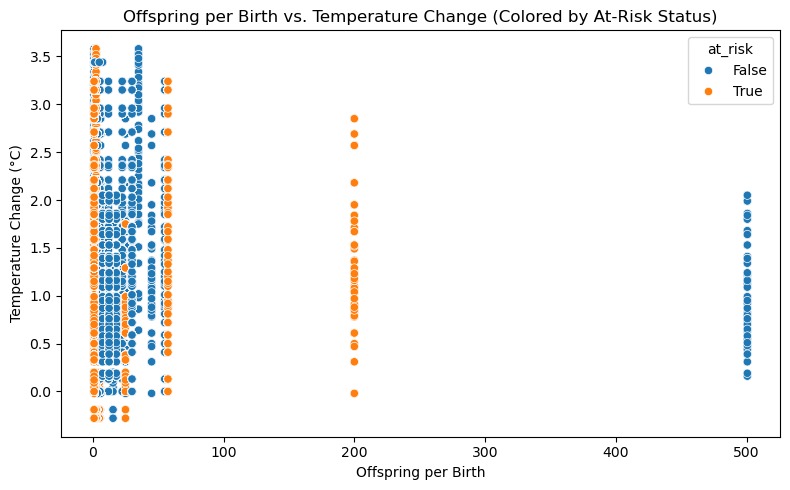

In [324]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_merged, x='Offspring per Birth', y='temp_change', hue='at_risk')
plt.title("Offspring per Birth vs. Temperature Change (Colored by At-Risk Status)")
plt.xlabel("Offspring per Birth")
plt.ylabel("Temperature Change (°C)")
plt.tight_layout()
plt.show()

In [325]:
df_merged[['Offspring per Birth', 'temp_change']].corr()


,Offspring per Birth,temp_change
Offspring per Birth,1.000000,-0.014304
temp_change,-0.014304,1.000000


In [326]:
df_merged.groupby('at_risk')['Offspring per Birth'].mean()


at_risk
False    14.166780
True     10.001196
Name: Offspring per Birth, dtype: float64

##### This plot examines the relationship between the number of offspring per birth and temperature change, while also distinguishing between at-risk and non-at-risk species. Although the data points are scattered and no strong trend is visually evident, the average number of offspring is slightly lower for at-risk species (10.0) compared to those not at risk (14.17). This supports part of the hypothesis that species with lower reproductive output may face higher extinction vulnerability. However, the correlation between offspring count and temperature change is extremely weak (r = -0.014), suggesting temperature trends alone do not explain reproductive vulnerability. The result invites further exploration into how offspring quantity interacts with other biological traits under climate pressure.

#### 6. **Boxplot showing Habitat Type vs. Average Temperature Change**

##### Since there were too many different kinds of habitats, I had to simplify it so that it could show up on the plot

In [346]:
habitat_map = {
    'Grasslands': 'Grasslands',
    'Savanna': 'Grasslands',
    'Scrub': 'Grasslands',
    'Forest': 'Forests',
    'Rainforest': 'Forests',
    'Jungle': 'Forests',
    'Desert': 'Deserts',
    'Wetland': 'Wetlands',
    'Swamp': 'Wetlands',
    'Marsh': 'Wetlands',
    'Ocean': 'Oceans',
    'Sea': 'Oceans',
    'Coastal': 'Oceans',
    'Reef': 'Oceans',
    'Lake': 'Freshwater',
    'River': 'Freshwater',
    'Freshwater': 'Freshwater',
    'Mountain': 'Mountains',
    'Alpine': 'Mountains',
    'Urban': 'Urban',
    'City': 'Urban',
    'Tundra': 'Tundra',
    'Cave': 'Other',
    'Underground': 'Other',
    'Unknown': 'Other',
    'Varies': 'Other'
}

In [347]:
def simplify_habitat(habitat_str):
    for keyword, category in habitat_map.items():
        if keyword.lower() in habitat_str.lower():
            return category
    return 'Other'

# Applying new column
df_merged['Habitat Category'] = df_merged['Habitat'].apply(simplify_habitat)


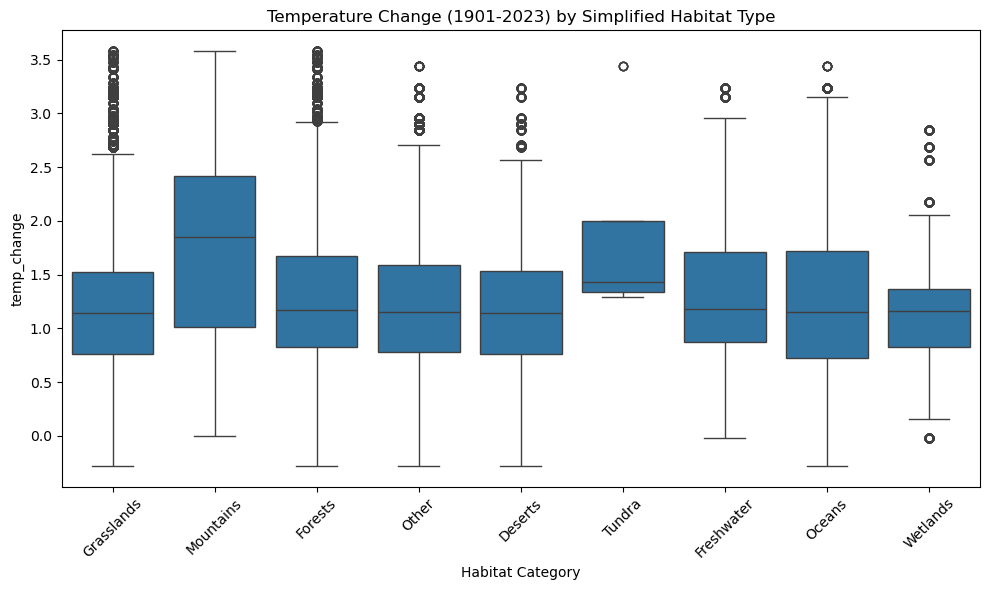

In [349]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df_merged, x='Habitat Category', y='temp_change')
plt.title("Temperature Change (1901-2023) by Simplified Habitat Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [351]:
df_merged.groupby('Habitat Category')['temp_change'].mean().sort_values()


Habitat Category
Wetlands      1.160530
Deserts       1.189168
Grasslands    1.192192
Oceans        1.210886
Other         1.215093
Forests       1.267986
Freshwater    1.320634
Mountains     1.808311
Tundra        1.900000
Name: temp_change, dtype: float64

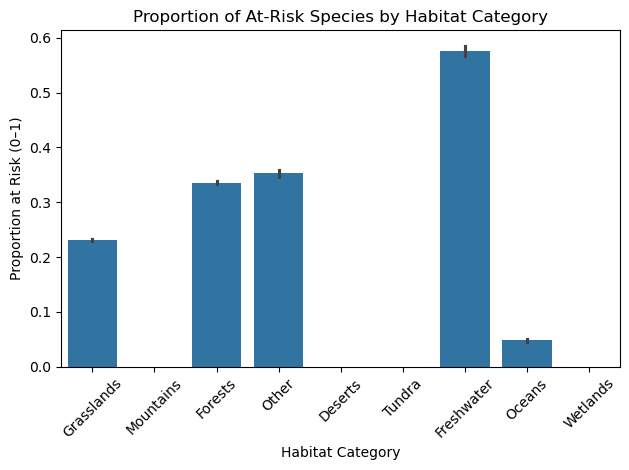

In [352]:
sns.barplot(data=df_merged, x='Habitat Category', y='at_risk')
plt.title("Proportion of At-Risk Species by Habitat Category")
plt.ylabel("Proportion at Risk (0–1)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


##### When grouped into broader categories, habitats show notable variation in both temperature change and species vulnerability.

##### In the first plot, we saw that Tundra and Mountain habitats experienced the most significant warming since 1901 — with average temperature increases of 1.9°C and 1.8°C, respectively.

##### In the second plot, this warming correlates with increased extinction vulnerability:

- Freshwater habitats, though slightly cooler than tundras, show the highest proportion of at-risk species, nearing 60%.

- Mountain and Forest habitats also show higher risk levels (~35%), possibly due to ecosystem fragility and habitat fragmentation.

- Conversely, Oceans and Wetlands, despite having variable temperature shifts, display lower proportions of at-risk species.

##### These two plots together support the hypothesis that habitat type plays a significant role in extinction vulnerability, especially when paired with climate exposure.
##### Habitats experiencing more intense warming often also show higher species sensitivity, particularly those with limited ecological flexibility or geographic isolation.